In [1]:
import math as m
import os
from pathlib import Path
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt
import vice

In [2]:
OUTPUT_DIR = Path('../src/data/onezone/twoinfall')
END_TIME = 13.2
DT = 0.01
SIMTIME = np.arange(0, END_TIME+DT, DT)

In [3]:
# from vice.yields.sneia import iwamoto99
# from vice.yields.ccsne import WW95
from vice.yields.presets import JW20
vice.yields.sneia.settings['fe'] *= 0.4
vice.yields.ccsne.settings['fe'] *= 0.3
vice.yields.ccsne.settings['o'] *= 0.3

In [4]:
class exponential:
    def __init__(self, timescale=1, coeff=1):
        self.timescale = timescale
        self.coeff = coeff
        
    def __call__(self, time):
        return self.coeff / self.timescale * m.exp(-time / self.timescale)
        
def polyfit(radius, params, col):
    fit = Polynomial.fit(params[:,0], params[:,col], deg=2, 
                         w=1/params[:,col+1])
    return fit(radius)

In [5]:
class spitoni_ifr:
    def __init__(self, radius):
        fit_params = np.genfromtxt('spitoni_twoinfall.dat')
        first_timescale = polyfit(radius, fit_params, 3)
        second_timescale = polyfit(radius, fit_params, 5)
        thin_to_thick = polyfit(radius, fit_params, 7)
        self.second_onset = polyfit(radius, fit_params, 9)
        self.first = exponential(
            timescale = first_timescale,
            coeff = 1 / (1 - m.exp(-END_TIME / first_timescale))
        )
        self.second = exponential(
            timescale = second_timescale,
            coeff = thin_to_thick / (1 - m.exp(
                -(END_TIME - self.second_onset) / second_timescale
            ))
        )
        
    def __call__(self, time):
        ifr = self.first(time)
        if time >= self.second_onset:
            ifr += self.second(time - self.second_onset)
        return ifr
    
class spitoni_tau_star:
    def __init__(self, radius):
        fit_params = np.genfromtxt('spitoni_twoinfall.dat')
        self.radius = radius
        self.second_onset = polyfit(radius, fit_params, 9)

    def __call__(self, time):
        if time < self.second_onset:
            return 1 / self.sfe1
        else:
            return 1 / self.sfe2
      
    @property
    def sfe1(self):
        if self.radius < 8.:
            return 4 - (self.radius / 4)
        else:
            return 2
        
    @property
    def sfe2(self):
        return max(2 - (self.radius / 8), 1e-6)

/home/lodubay/anaconda3/lib/python3.9/site-packages/vice/core/singlezone/singlezone.py:258: ScienceWarning: Closed-box GCE models have been shown to overpredict the metallicities of solar neighborhood stars. This was known as the G-dwarf problem (Tinsley 1980, Fundamentals of Cosmic Phys., 5, 287). Outflows have been shown to be necessary for maintaining long-term chemical equilibrium (Dalcanton 2007, ApJ, 658, 941).
  self.__c_version = c_singlezone(**kwargs)


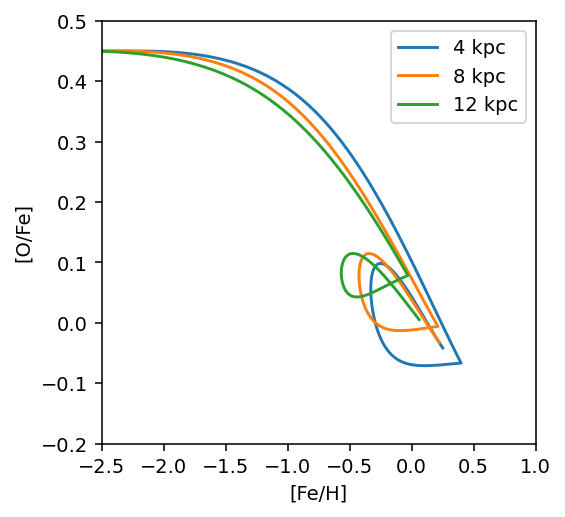

In [6]:
for galr in [4, 8, 12]:
    sz = vice.singlezone(
        name=str(OUTPUT_DIR / f'spitoni{galr:02d}'), 
        func=spitoni_ifr(galr), 
        tau_star=spitoni_tau_star(galr),
        mode='ifr',
        eta=0,  
        Mg0=0,
        elements=('fe', 'o'),
        dt=DT,
        recycling='continuous',
        RIa=exponential(timescale=1.5),
        delay=0.04,
        schmidt=True
    )
    sz.run(SIMTIME, overwrite=True)

fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
for galr in [4, 8, 12]:
    hist = vice.history(str(OUTPUT_DIR / f'spitoni{galr:02d}'))
    ax.plot(hist['[fe/h]'], hist['[o/fe]'], label='%s kpc' % galr)
ax.set_xlim((-2.5, 1))
ax.set_ylim((-0.2, 0.5))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.legend()
plt.show()

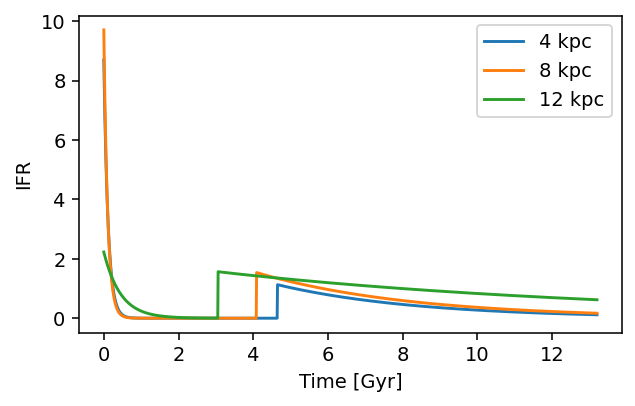

In [7]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=140)
for galr in [4, 8, 12]:
    ifr = spitoni_ifr(galr)
    ax.plot(SIMTIME, [ifr(t) for t in SIMTIME], label='%s kpc' % galr)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('IFR')
ax.legend()
plt.show()

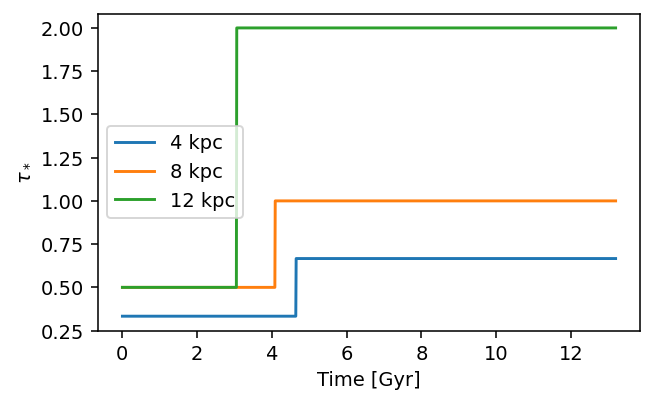

In [8]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=140)
for galr in [4, 8, 12]:
    tau_star = spitoni_tau_star(galr)
    ax.plot(SIMTIME, [tau_star(t) for t in SIMTIME], label='%s kpc' % galr)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$\tau_*$')
ax.legend()
plt.show()

In [21]:
class approx_ifr:
    def __init__(self, radius, first_timescale=0.1, second_timescale=4, 
                 thin_to_thick=5.6, second_onset=4):
        self.second_onset = second_onset
        self.first = exponential(
            timescale = first_timescale,
            coeff = 1 / (1 - m.exp(-END_TIME / first_timescale))
        )
        self.second = exponential(
            timescale = second_timescale,
            coeff = thin_to_thick / (1 - m.exp(
                -(END_TIME - self.second_onset) / second_timescale
            ))
        )
        
    def __call__(self, time):
        ifr = self.first(time)
        if time >= self.second_onset:
            ifr += self.second(time - self.second_onset)
        return ifr
    
class approx_tau_star:
    def __init__(self, radius, second_onset=4):
        self.radius = radius
        self.second_onset = second_onset

    def __call__(self, time):
        if time < self.second_onset:
            return 1 / self.sfe1
        else:
            return 1 / self.sfe2
      
    @property
    def sfe1(self):
        if self.radius < 8.:
            return 4 - (self.radius / 4)
        else:
            return 2
        
    @property
    def sfe2(self):
        return max(2 - (self.radius / 8), 1e-6)

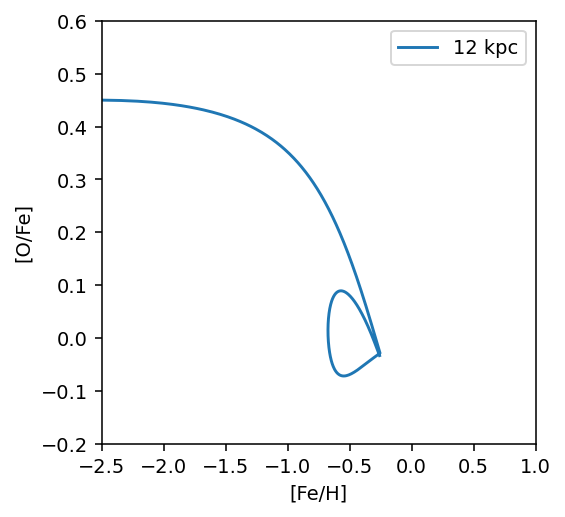

In [93]:
galr = 12
sz = vice.singlezone(
    name=str(OUTPUT_DIR / f'approx{galr:02d}'), 
    func=approx_ifr(galr, first_timescale=3, second_timescale=10, thin_to_thick=2, second_onset=4), 
    tau_star=approx_tau_star(galr, second_onset=4),
    mode='ifr',
    eta=vice.milkyway.default_mass_loading(galr), 
    Mg0=0,
    elements=('fe', 'o'),
    dt=DT,
    recycling='continuous',
    RIa=exponential(timescale=1.5),
    delay=0.04,
    schmidt=True
)
sz.run(SIMTIME, overwrite=True)

fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
hist = vice.history(str(OUTPUT_DIR / f'approx{galr:02d}'))
ax.plot(hist['[fe/h]'], hist['[o/fe]'], label='%s kpc' % galr)
ax.set_xlim((-2.5, 1))
ax.set_ylim((-0.2, 0.6))
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
ax.legend()
plt.show()